# Exploratory Data Analysis

# Imports, Read-in

In [126]:
# Data manip.
import pandas as pd
import numpy as np

# Vizz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# scikit-learn
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
sw = stopwords.words('english')

# etc.
import sys
sys.path.append( '../src' )
from xgboost import XGBClassifier, XGBRFClassifier
from parse_it import get_wordnet_pos, parse_doc
from pretty_results import *

The data is stored in two separate `.csv` files.

In [127]:
df_good = pd.read_csv('../../data/good.csv')
df_promo = pd.read_csv('../../data/promotional.csv')

Taking a look at a sample article from the `good` articles dataset.

In [128]:
df_good.iloc[12345].text

"Jamal A Davis Here I Stand is a song by American recording artist Usher. It was sent to urban adult contemporary radio on August 18, 2008 by LaFace Records and RCA Records as the fifth single from Usher's fifth studio album of the same name. Penned by the singer with Polow da Don, Adam Blackstone, Gerrell Gaddis, and Dre Vidal, and produced by Dre Vidal, Here I Stand is a slow soul ballad and contains similarities to Stevie Wonder's music. The record was nominated for the Best Male R B Vocal Performance award at the 51st Grammy Awards. Here I Stand maintained a position on the United States Hot R B Hip Hop Songs for several weeks in 2008 and 2009, reaching the top twenty. It also appeared on the US Radio Songs and Bubbling Under Hot 100 Singles charts, peaking at numbers seventy two and six, respectively. Here I Stand was written by Usher, Polow da Don, Adam Blackstone and Gerrell Gaddis, as well as Dre Vidal, who also produced the track. The song was recorded by Vincent Dilorenzo, wi

Testing out a custom function, `parse_doc`, which takes care of several NLP preprocessing steps: lowercasing, punctuation and character stripping, lemmatizing, and removing stopwords. It returns a string of *non-unique lemmas*, but can also return a list by setting the argument `as_list = True`. If stemming is preferred to lemmatizing, this can also be done within the function: `stem = 'stem'`.

In [129]:
parse_doc( df_good.iloc[12345].text )

'jamal davis stand song american record artist usher send urban adult contemporary radio august laface record rca record fifth single usher fifth studio album name pen singer polow da adam blackstone gerrell gaddi dre vidal produce dre vidal stand slow soul ballad contain similarity stevie wonder music record nominate best male r b vocal performance award st grammy award stand maintain position united state hot r b hip hop songs several week reach top twenty also appear u radio song bubble hot single chart peak number seventy two six respectively stand write usher polow da adam blackstone gerrell gaddis well dre vidal also produce track song record vincent dilorenzo assistance geoff rice sony music studios new york city zac record atlanta dilorenzo also mixed record assistance matt desando studio philadelphia accord josh eells blender stand write tameka foster usher marry august compose engagement stand play usher foster wed foster request tune assurance sexual fidelity commitment inte

And, just to get the lay of the land, a look at one of the `promotional` articles.

In [130]:
df_promo.iloc[12345].text

'Love Justice International LJI , formerly Tiny Hands International, is a nonprofit organization dedicated to combating social injustice. Love Justice was established in 2005 and is based in Lincoln, Nebraska. Through a child sponsorship program, Love Justice International currently operates 18 family like childrens homes for over 200 orphaned and abandoned children in South Asia. In 2015 Love Justice established a K 12 school located in South Asia. The school provides education for over 150 children in this region. Love Justice developed a strategy called transit monitoring and interception. The strategy is to attack trafficking while it is in the process of occurring and before exploitation and enslavement. The staff monitors at border crossings, bus stations, train stations, and airports, and they look for signs of human trafficking. Love Justice currently operates in 11 countries throughout Asia and Africa, and they have intercepted over 15,000 people who were at risk of human traf

In [131]:
parse_doc(df_promo.iloc[12345].text)

'love justice international lji formerly tiny hand international nonprofit organization dedicate combat social injustice love justice establish base lincoln nebraska child sponsorship program love justice international currently operate family like childrens home orphan abandoned child south asia love justice establish k school locate south asia school provide education child region love justice develop strategy call transit monitoring interception strategy attack traffic process occur exploitation enslavement staff monitor border crossing bus station train station airport look sign human traffic love justice currently operate country throughout asia africa intercept people risk human traffic love justice international acquires detail data traffic victim information upload database use help well understand fight traffic network around world intelligence lead investigation love justice collaborates local police us detail actionable data arrest prosecute convict trafficker effort result 

# Sample Size, Scope, and Content

In [132]:
print(df_good.shape)
print(df_promo.shape)

(30279, 2)
(23837, 7)


In [133]:
df_good.shape[0] + df_promo.shape[0]

54116

In terms of **rows/records**,
- The dataframe containing **"good"** articles has 30,279 entries.
- The dataframe containing **"promotional"** articles has 23,837 entries.

Combined, we have **54,116** articles for examination.

Next, let's discuss features/columns.

In [134]:
print(df_good.columns)
print(df_promo.columns)

Index(['text', 'url'], dtype='object')
Index(['text', 'advert', 'coi', 'fanpov', 'pr', 'resume', 'url'], dtype='object')


- The dataframe containing **"good"** articles has 2 columns - `text` and `url`.
- The dataframe containing **"promotional"** articles has 7 columns - in addition to `text` and `url`, there are five subtypes of "promotional tone":

    - `advert`: The article reads like an advertisement.
    - `coi`: The article appears to have been written by someone with a close connection to the subject.
    - `fanpov`: The article appears to have been written from a fan's point of view, rather than a neutral point of view.
    - `pr`: The article reads like a press release/news article.
    - `resume`: The (biographical) article reads like a résumé, i.e. it is neither neutral nor encylopedic in nature.
    
    The values contained in these columns are one-hot encoded binary values. See the dataframe heads below for a tabular representation of the data.

In [135]:
df_good.head(3)

,text,url
0,Nycticebus linglom is a fossil strepsirrhine p...,https://en.wikipedia.org/wiki/%3F%20Nycticebus...
1,Oryzomys pliocaenicus is a fossil rodent from ...,https://en.wikipedia.org/wiki/%3F%20Oryzomys%2...
2,.hack dt hk is a series of single player actio...,https://en.wikipedia.org/wiki/.hack%20%28video...


In [136]:
df_promo.head(3)

,text,advert,coi,fanpov,pr,resume,url
0,"1 Litre no Namida 1, lit. 1 Litre of Tears als...",0,0,1,0,0,https://en.wikipedia.org/wiki/1%20Litre%20no%2...
1,"1DayLater was free, web based software that wa...",1,1,0,0,0,https://en.wikipedia.org/wiki/1DayLater
2,1E is a privately owned IT software and servic...,1,0,0,0,0,https://en.wikipedia.org/wiki/1E


### Side Investigation: Average Length of Articles?

While reading in the data, I noticed that the `promotional` article I selected at semi-random was considerably shorter than the semi-random `good` article - I had to wonder if this observation held true at all in the rest of the dataset and decided to investigate average article length for each class.

`len()` can give us a count of characters - `split()` must be used to get a word count.

In [137]:
print(f"Character count in first 'good' article: {len(df_good.iloc[0].text)}")
print(f"Word count in first 'good' article: {len(df_good.iloc[0].text.split())}")

Character count in first 'good' article: 3466
Word count in first 'good' article: 590


We can use string methods on the dataframes by calling `.str` - this makes calculations a lot easier.

In [138]:
df_good.text.str.len()

0         3466
1         3230
2        22691
3         5620
4         9303
         ...  
30274    32625
30275     6667
30276     9625
30277    15576
30278    11186
Name: text, Length: 30279, dtype: int64

In [139]:
df_promo.text.str.len()

0         3439
1         1546
2         5550
3        11461
4         1300
         ...  
23832      895
23833     2677
23834     1306
23835     4642
23836     2946
Name: text, Length: 23837, dtype: int64

In [140]:
avg_char_good = df_good.text.str.len().mean()
avg_char_promo = df_promo.text.str.len().mean()

In [141]:
split_words_good = df_good.text.str.split()
split_words_promo = df_promo.text.str.split()

In [142]:
word_count_good = 0

for article in split_words_good:
    word_count_good += len(article)
    
avg_words_good = word_count_good / len(split_words_good)

print(avg_words_good)

2628.5815581756333


In [143]:
word_count_promo = 0

for article in split_words_promo:
    word_count_promo += len(article)
    
avg_words_promo = word_count_promo / len(split_words_promo)

print(avg_words_promo)

768.2722658052608


In [144]:
print(f"Average 'good' article length: {avg_char_good:.0f} characters, {avg_words_good:.0f} words")
print(f"Average 'promotional' article length: {avg_char_promo:.0f} characters, {avg_words_promo:.0f} words\n")
print(f"Rough calc of characters per word, 'good' articles: {(avg_char_good / avg_words_good):.2f}")
print(f"Rough calc of characters per word, 'promotional' articles: {(avg_char_promo / avg_words_promo):.2f}\n")
print(f"On average, 'good' articles are {(avg_words_good / avg_words_promo):.1f} times longer than 'promotional' articles")

Average 'good' article length: 15649 characters, 2629 words
Average 'promotional' article length: 4771 characters, 768 words

Rough calc of characters per word, 'good' articles: 5.95
Rough calc of characters per word, 'promotional' articles: 6.21

On average, 'good' articles are 3.4 times longer than 'promotional' articles


In [145]:
plt.style.use('seaborn-dark')

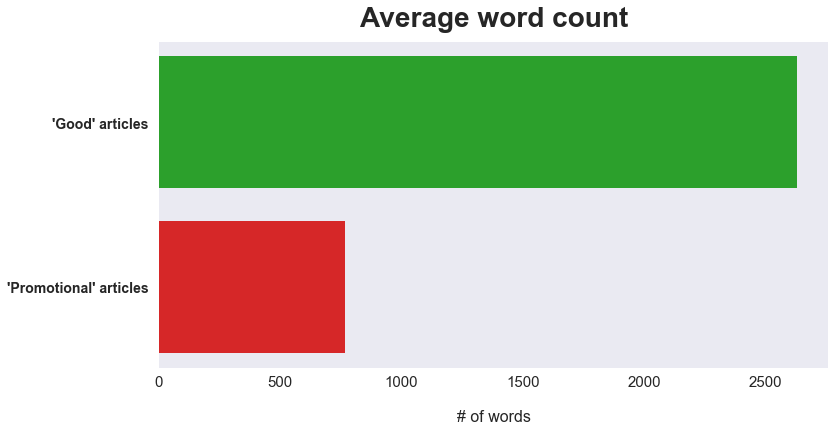

In [147]:
# Visualization of average lengths
fig, ax = plt.subplots(figsize=(12, 6))

plt.xticks(fontsize=15)
plt.yticks(fontsize=14, fontweight='bold')
ax.tick_params(axis='y', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=7)


ax.barh(y=["'Promotional' articles", "'Good' articles"],
        width=(avg_words_promo, avg_words_good),
        color=['tab:red', 'tab:green'])

ax.set_title("Average word count",
             pad=15,
             fontsize=28,
             fontweight='bold')
ax.set_xlabel("# of words",
              labelpad=20,
              fontsize=16)

fig.savefig(fname='../images/avg_word_count.png',
            dpi=600,
            bbox_inches='tight')

## Checking for Nulls / Data Types

In [148]:
df_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30279 entries, 0 to 30278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30279 non-null  object
 1   url     30279 non-null  object
dtypes: object(2)
memory usage: 473.2+ KB


In [149]:
df_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23837 entries, 0 to 23836
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23837 non-null  object
 1   advert  23837 non-null  int64 
 2   coi     23837 non-null  int64 
 3   fanpov  23837 non-null  int64 
 4   pr      23837 non-null  int64 
 5   resume  23837 non-null  int64 
 6   url     23837 non-null  object
dtypes: int64(5), object(2)
memory usage: 1.3+ MB


No nulls in either dataframe. Text is predictably coded as an object/string, and `df_promo` comes with some labels built in: one-hot encoded columns that indicate *subclass* of promotional article.

## Value Counts for Subclasses

Knowing there are five different subtypes of promotional article indicated within the dataset raises a further question: *how are those subtypes distributed?*

In [150]:
df_promo.select_dtypes(include='number').columns

Index(['advert', 'coi', 'fanpov', 'pr', 'resume'], dtype='object')

In [151]:
# class_cols = df_promo.select_dtypes(include='number').columns
class_cols = df_promo.select_dtypes(include='number').columns.tolist()

class_cols

['advert', 'coi', 'fanpov', 'pr', 'resume']

In [152]:
for col in class_cols:
    print(f"{df_promo[[col]].value_counts(normalize=True)}\n")

advert
1         0.793346
0         0.206654
dtype: float64

coi
0      0.91014
1      0.08986
dtype: float64

fanpov
0         0.93724
1         0.06276
dtype: float64

pr
0     0.936401
1     0.063599
dtype: float64

resume
0         0.90779
1         0.09221
dtype: float64



In [153]:
advert_posi = df_promo.advert.value_counts(normalize=True).values[0]
coi_posi = df_promo.coi.value_counts(normalize=True).values[1]
fanpov_posi = df_promo.fanpov.value_counts(normalize=True).values[1]
pr_posi = df_promo.pr.value_counts(normalize=True).values[1]
resume_posi = df_promo.resume.value_counts(normalize=True).values[1]

posi_counts = [advert_posi, coi_posi, fanpov_posi, pr_posi, resume_posi]

posi_counts

[0.7933464781641986,
 0.08986030121240089,
 0.06275957544993079,
 0.06359860720728279,
 0.09220959013298653]

In [154]:
df_promo.columns

Index(['text', 'advert', 'coi', 'fanpov', 'pr', 'resume', 'url'], dtype='object')

In [155]:
# fig, ax = plt.subplots(nrows=1,
#                        ncols=5,
#                        figsize=(30,6),
#                        sharey='all')

# ax[0].bar(x=df_promo['advert'].value_counts(normalize=True).index,
#           height=df_promo['advert'].value_counts(normalize=True).values,
#           tick_label=['True', 'False'])
# ax[0].set_title("Advertisement-like")

# ax[1].bar(x=df_promo['coi'].value_counts(normalize=True).index,
#           height=df_promo['coi'].value_counts(normalize=True).values,
#           tick_label=['False', 'True'])
# ax[1].set_title("Conflict of interest")

# ax[2].bar(x=df_promo['fanpov'].value_counts(normalize=True).index,
#           height=df_promo['fanpov'].value_counts(normalize=True).values,
#           tick_label=['False', 'True'])
# ax[2].set_title("Written from fan's point of view")

# ax[3].bar(x=df_promo['pr'].value_counts(normalize=True).index,
#           height=df_promo['pr'].value_counts(normalize=True).values,
#           tick_label=['False', 'True'])
# ax[3].set_title("Written like a news article/press release")

# ax[4].bar(x=df_promo['resume'].value_counts(normalize=True).index,
#           height=df_promo['resume'].value_counts(normalize=True).values,
#           tick_label=['False', 'True'])
# ax[4].set_title("Reads like a résumé");

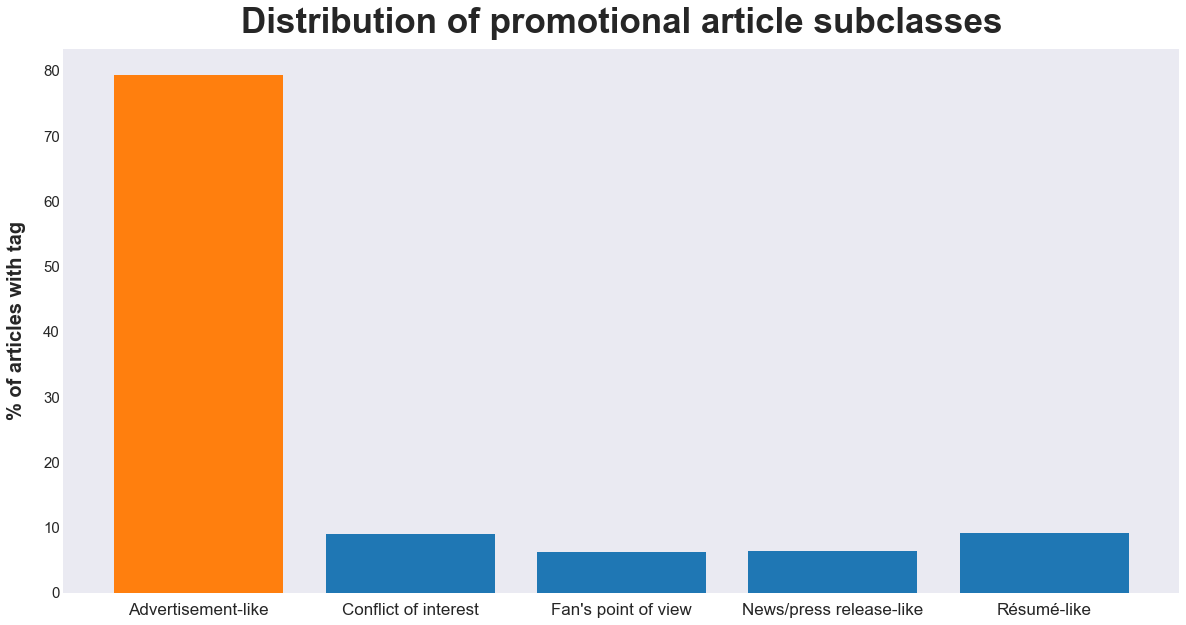

In [156]:
fig, ax = plt.subplots(figsize=(20, 10))

y_ticks = np.linspace(0, 0.8, 9)
y_tick_labels = []

for x in np.linspace(0, 80, 9).tolist():
    x = str(x).replace('.0', '')
    y_tick_labels.append(x)

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
ax.tick_params(axis='x', which='major', pad=10)   
    
ax.bar(x=["Advertisement-like",
          "Conflict of interest",
          "Fan's point of view",
          "News/press release-like",
          "Résumé-like"],
       height=posi_counts,
       color=['tab:orange', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue'])

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels,
                   fontsize=15)
ax.set_ylabel("% of articles with tag",
              fontsize = 20,
              fontweight='semibold',
              labelpad = 17)
ax.set_title("Distribution of promotional article subclasses",
             fontsize=35,
             fontweight='bold',
             pad=16)

fig.savefig(fname='../images/promo_dist.png',
            dpi=600,
            bbox_inches='tight');

# Set-up for Simple Binary Classification

First, we drop all columns but `text`, which will be our primary feature.

In [55]:
df_good = df_good[['text']]
df_promo = df_promo[['text']]

Before concatening the simplified dataframes, I create a new column `label` in each dataframe and give it the same value in every row. In `df_good`, each row is given the label `0` to indicate `False`, i.e. the article does ***not*** have a promotional tone. Conversely, each row in `df_promo` is given the label `1` to represent `True`, that the article ***does*** contain content that is promotional in tone.

Multi-class classification is explored in a [separate notebook](Multi-label.ipynb).

In [56]:
df_good['label'] = 0
df_good.head(3)

,text,label
0,Nycticebus linglom is a fossil strepsirrhine p...,0
1,Oryzomys pliocaenicus is a fossil rodent from ...,0
2,.hack dt hk is a series of single player actio...,0


In [57]:
df_promo['label'] = 1
df_promo.head(3)

,text,label
0,"1 Litre no Namida 1, lit. 1 Litre of Tears als...",1
1,"1DayLater was free, web based software that wa...",1
2,1E is a privately owned IT software and servic...,1


Next, we concatenate the dataframes using the pandas method `.append` - setting `ignore_index` to `True` means that the unique index values from `df_promo` are not carried over when this dataframe is appended to `df_good`; the indexing, rather, continues where `df_good`'s index leaves off.

In [58]:
df = df_good.append(other=df_promo,
                    ignore_index=True)

df

,text,label
0,Nycticebus linglom is a fossil strepsirrhine p...,0
1,Oryzomys pliocaenicus is a fossil rodent from ...,0
2,.hack dt hk is a series of single player actio...,0
3,The You Drive Me Crazy Tour was the second con...,0
4,0 8 4 is the second episode of the first seaso...,0
...,...,...
54111,ZURICH.MINDS is a non profit foundation set up...,1
54112,"zvelo, Inc. or simply zvelo is a privately hel...",1
54113,Zygote Media Group is a 3D human anatomy conte...,1
54114,Zylom is a distributor of casual games for PC ...,1


The following code cell shuffles the index of the dataframe so that `good` and `promotional` articles are mixed in together. This is included purely for the purpose of reproducibility, which is why the next few cells (prior to section `Reading in .csv file with lemmas`) are commented out.

In [65]:
df = df.sample(frac=1,
               random_state=138).reset_index(drop=True)

df

,text,label
0,Mutares AG styled Mutares is a German based ho...,1
1,Federico Martinez Roda is a professor of histo...,1
2,Jorg M. Colberg born 15 February 1968 writes a...,1
3,Signal 30 is the fifth episode of the fifth se...,0
4,M 247 is a northsouth state trunkline highway ...,0
...,...,...
54111,Swaziland competed at the 2012 Summer Olympics...,0
54112,"Established on April 1, 2007, the Interactive ...",1
54113,Student directed teaching is a teaching techno...,1
54114,Nobody's Business is a song recorded by Barbad...,0


In [66]:
# freq_out(df, 'text', 10)

The following cell is one of the most computationally expensive tasks in this whole project - it applies the custom function `parse_doc` (see the [.py file](../src/parse_it.py) for further information) to the content of the `text` column for each row in the dataframe, i.e. each document in the corpus. The result is a string of **lemmas**, the approximate morphological roots of each word in the document, stored in a new column called `text_lem`. This helps standardize the text for vectorization and, eventually, modeling.

Again, the following two cells are only necessary to run if you're interested in completing reproducing the project, step by step. For convenience, the output is saved as a `.csv` file, which 

In [ ]:
# df['text_lem'] = df['text'].apply(parse_doc) 

In [ ]:
# df.to_csv('lemmed_combined.csv')

## Reading in Newly Created csv file (with lemmas)

In [75]:
lemmed_df = pd.read_csv('../../data/lemmed_combined.csv', index_col=0)

In [76]:
lemmed_df.head(3)

,text,label,text_lem
0,"Ryan Steven Lochte lkti LOK tee born August 3,...",0,ryan steven lochte lkti lok tee bear august am...
1,CAM ships were World War II era British mercha...,0,cam ship world war ii era british merchant shi...
2,The politics of Vietnam are defined by a singl...,0,politics vietnam define single party socialist...


In [ ]:
additional_sw = ['january',
                 'february',
                 'april', # 'march' and 'may' are English verbs and
                          #  are thus excluded
                 'june',
                 'july',
                 'august',
                 'september',
                 'october',
                 'november',
                 'december']

# Modeling Setup/Brainstorming

In [77]:
X = lemmed_df['text_lem']
y = lemmed_df['label']

In [78]:
X

0        ryan steven lochte lkti lok tee bear august am...
1        cam ship world war ii era british merchant shi...
2        politics vietnam define single party socialist...
3        pennsylvania route pa state highway locate mon...
4        clubland tv british free air dance music chann...
                               ...                        
54111    guatemala send delegation compete summer paral...
54112    charles augustus ollivierre july march vincent...
54113    dhanushka jayakody bear july colombo sri lanka...
54114    elmer harrison flick january january american ...
54115    safdarjung tomb sandstone marble mausoleum del...
Name: text_lem, Length: 54116, dtype: object

In [79]:
y

0        0
1        0
2        0
3        0
4        1
        ..
54111    0
54112    0
54113    1
54114    0
54115    0
Name: label, Length: 54116, dtype: int64

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    stratify=y)

In [81]:
y_train.value_counts(normalize=True)

0    0.559533
1    0.440467
Name: label, dtype: float64

In [82]:
y_test.value_counts(normalize=True)

0    0.559494
1    0.440506
Name: label, dtype: float64

## `DummyClassifier`

In [83]:
dum_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

dum_cv_res = cross_validate(dum_pipe,
                            X_train,
                            y_train,
                            scoring=('accuracy', 'f1_macro'),
                            cv=5,
                            verbose=1,
                            n_jobs=-2,
                            return_train_score=True)

pretty_cv(dum_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.560
Test accuracy:     0.560
F-1 Score
--------------------------------
Training F1 score: 0.359
Test F1 score:     0.359


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  2.4min finished


Results from cross-validation with `DummyClassifier`, count vectorized:
- Validation accuracy = `0.56` - proportion of majority class, and **baseline performance**
- Validation F1 = `0.36`
- **Execution time:** 1m, 30s

In [84]:
dum_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

dum_tfidf_cv_res = cross_validate(dum_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(dum_tfidf_cv_res)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.560
Test accuracy:     0.560
F-1 Score
--------------------------------
Training F1 score: 0.359
Test F1 score:     0.359


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  2.6min finished


Results from cross-validation with `DummyClassifier`, TF-IDF vectorized:
- Validation accuracy = `0.56`
- Validation F1 = `0.36`
- **Execution time:** 2m, 38s

## `DecisionTreeClassifier`

In [ ]:
dtc_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('dtc', DecisionTreeClassifier())
])

dtc_cv_res = cross_validate(dtc_pipe,
                            X_train,
                            y_train,
                            scoring=('accuracy', 'f1_macro'),
                            cv=5,
                            verbose=1,
                            n_jobs=-2,
                            return_train_score=True)

pretty_cv(dtc_cv_res)

Results from cross-validation with `DecisionTreeClassifer`, count vectorized:
- Validation accuracy = `0.87`
- Validation F1 = `0.87`
- **Execution time:** 3m, 57s

In [ ]:
dtc_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('dtc', DecisionTreeClassifier())
])

dtc_tfidf_cv_res = cross_validate(dtc_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(dtc_tfidf_cv_res)

Results from cross-validation with `DecisionTreeClassifer`, TF-IDF vectorized:
- Validation accuracy = `0.86`
- Validation F1 = `0.86`
- **Execution time:** 8m, 55s

## `MultinomialNB`

In [ ]:
mnb_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

mnb_cv_res = cross_validate(mnb_pipe,
                            X_train,
                            y_train,
                            scoring=('accuracy', 'f1_macro'),
                            cv=5,
                            verbose=1,
                            n_jobs=-2,
                            return_train_score=True)

pretty_cv(mnb_cv_res)

Results from cross-validation with `MultinomialNB`, count vectorized:
- Validation accuracy = `0.90`
- Validation F1 = `0.90`
- **Execution time:** 2m, 25s

In [ ]:
mnb_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

mnb_tfidf_cv_res = cross_validate(mnb_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(mnb_tfidf_cv_res)

Results from cross-validation with `MultinomialNB`, TF-IDF vectorized:
- Validation accuracy = `0.79`
- Validation F1 = `0.77`
- **Execution time:** 2m, 32s

## `RandomForestClassifier`

In [ ]:
rfc_cvec_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

rfc_cvec_cv_res = cross_validate(rfc_cvec_pipe,
                                 X_train,
                                 y_train,
                                 scoring=('accuracy', 'f1_macro'),
                                 cv=5,
                                 verbose=1,
                                 n_jobs=-2,
                                 return_train_score=True)

pretty_cv(rfc_cvec_cv_res)

Results from cross-validation with `RandomForestClassifer`, count vectorized:
- Validation accuracy = `0.93`
- Validation F1 = `0.92`
- **Execution time:** 9m, 44s

In [ ]:
rfc_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])

rfc_tfidf_cv_res = cross_validate(rfc_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(rfc_tfidf_cv_res)

Results from cross-validation with `RandomForestClassifer`, TF-IDF vectorized:
- Validation accuracy = `0.93`
- Validation F1 = `0.93`
- **Execution time:** 6m, 37s

## `GradientBoostingClassifier`

In [ ]:
gbc_cvec_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('gbc', GradientBoostingClassifier())
])

gbc_cvec_cv_res = cross_validate(gbc_cvec_pipe,
                                 X_train,
                                 y_train,
                                 scoring=('accuracy', 'f1_macro'),
                                 cv=5,
                                 verbose=1,
                                 n_jobs=-2,
                                 return_train_score=True)

pretty_cv(gbc_cvec_cv_res)

Results from cross-validation with `GradientBoostingClassifier`, count vectorized:
- Validation accuracy = `0.93`
- Validation F1 = `0.93`
- **Execution time:** 12m, 25s

In [ ]:
gbc_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('gbc', GradientBoostingClassifier())
])

gbc_tfidf_cv_res = cross_validate(gbc_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(gbc_tfidf_cv_res)

Results from cross-validation with `GradientBoostingClassifier`, TF-IDF vectorized:
- Validation accuracy = `0.94`
- Validation F1 = `0.94`
- **Execution time:** 25m, 5s

## `XGBClassifier`

In [ ]:
xgb_cvec_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier())
])

xgb_cvec_cv_res = cross_validate(xgb_cvec_pipe,
                                 X_train,
                                 y_train,
                                 scoring=('accuracy', 'f1_macro'),
                                 cv=5,
                                 verbose=1,
                                 n_jobs=-2,
                                 return_train_score=True)

pretty_cv(xgb_cvec_cv_res)

Results from cross-validation with `XGBClassifier`, count vectorized:
- Validation accuracy = `0.95`
- Validation F1 = `0.95`
- **Execution time:** 8m, 47s

In [ ]:
xgb_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

xgb_tfidf_cv_res = cross_validate(xgb_tfidf_pipe,
                                  X_train,
                                  y_train,
                                  scoring=('accuracy', 'f1_macro'),
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-2,
                                  return_train_score=True)

pretty_cv(xgb_tfidf_cv_res)

Results from cross-validation with `XGBClassifier`, TF-IDF vectorized:
- Validation accuracy = `0.95`
- Validation F1 = `0.95`
- **Execution time:** 18m, 22s

## `XGBRFClassifier`

In [ ]:
xgbrf_cvec_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('xgbrf', XGBRFClassifier())
])

xgbrf_cvec_cv_res = cross_validate(xgbrf_cvec_pipe,
                                   X_train,
                                   y_train,
                                   scoring=('accuracy', 'f1_macro'),
                                   cv=5,
                                   verbose=1,
                                   n_jobs=-2,
                                   return_train_score=True)

pretty_cv(xgbrf_cvec_cv_res)

Results from cross-validation with `XGBRFClassifier`, count vectorized:
- Validation accuracy = `0.88`
- Validation F1 = `0.88`
- **Execution time:** 8m, 24s

In [ ]:
xgbrf_tfidf_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('xgbrf', XGBRFClassifier())
])

xgbrf_tfidf_cv_res = cross_validate(xgbrf_tfidf_pipe,
                                    X_train,
                                    y_train,
                                    scoring=('accuracy', 'f1_macro'),
                                    cv=5,
                                    verbose=1,
                                    n_jobs=-2,
                                    return_train_score=True)

pretty_cv(xgbrf_tfidf_cv_res)

Results from cross-validation with `XGBRFClassifier`, TF-IDF vectorized:
- Validation accuracy = `0.89`
- Validation F1 = `0.89`
- **Execution time:** 14m, 0s